# SLU11 - Tree-based models: Learning notebook

## Imports

In [1]:
from math import log2

import pandas as pd
import numpy as np

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from IPython.display import Image

from utils.utils import (
    make_data,
    separate_target_variable,
    process_categorical_features,
    visualize_tree
)

# Table of Contents

1. [Decision trees](#decision-trees)
2. [Tree-based ensembles](#tree-based-ensembles)
3. [Bagging with random forests](#bagging-with-random-forests)
4. [Boosting with gradient boosting](#boosting-with-gradient-boosting)

# Decision trees <a class="anchor" id="decision-trees"></a>

A **decision tree** is a decision support tool in a form of a tree-like structure, it can be used for classification or regression, being more used for classification, where each node is associated with a test on a feature, each branch represents an outcome of the test, and each leaf the final decision.

In order to explain you better how **decision trees** work lets use an example, where according with the weather we want to know if we should go hiking. A simple **decision tree** can be represented as:

<img src="assets/simple-decision-tree.png" alt="simple-decision-tree" style="width: 600px;"/>

*Fig. 1: A simple decision-tree used for classification (Quinlan, 1986).*

This **decision tree**, displays a flow of conditional statements (i.e., `if Condition then Outcome`) where:

* Each **node** represents a test on a feature (E.g. is it windy?)
* Each **branch** represents the outcome of the test (E.g. as true or false)
* Each **leaf** represents an outcome or decision (represented with N and P).

The paths from root to leaf represent the rules, e.g., `if Outlook is Sunny and Humidity is Normal then Go Hiking`.

## Learning sets of rules as decision trees

Typically, a decision tree is developed from the top-down (known as top-down induction), and there are several algorithms that can be used to build them, including:
* **Iterative Dichotomiser 3 (ID3)**, for classification using categorical features (use of entropy and information gain as metric.)
* **C4.5**, successor to ID3 to support non-categorical features
* **Classification and Regression Trees (CART)**, generalizes C4.5 to support regression (use of Gini impurity as the metric).

We follow ID3 ([Quinlan, 1986][1]), for binary classification using categorical features with a small set of possible values (i.e. low cardinality).

[1]: http://hunch.net/~coms-4771/quinlan.pdf "Quinlan, J. 1986. Induction of Decision Trees. Machine Learning 1: 81-106."

In [2]:
data = make_data()

### Algorithm overview

Take an arbitrary training set $C = \{\textbf{x}_i, y_i\}_{i=1}^m$, a collection of labeled observations, with $y_i \in \{L_1, \dots, L_v\}$.

The features vector is represented as $\textbf{x}_i = \{x_i^{(1)}, \dots, x_i^{(n)}\}$, where $x_i^{(j)}$ is the value of the $j$-th feature for the $i$-th observation.

In ID3, $x_i^{(j)}$ can take on one of a fixed number of possible values $x_i^{(j)} \in \{A_1^{(j)}, \dots, A_w^{(j)}\}$.

$$X = \begin{bmatrix}
  x_1^{(1)} & x_1^{(2)} & \dots & x_1^{(n)} \\
  x_2^{(1)} & x_2^{(2)} & \dots & x_2^{(n)} \\
  \dots     & \dots     & \dots & \dots     \\
  x_m^{(1)} & x_m^{(2)} & \dots & x_m^{(n)}
 \end{bmatrix}$$

In [3]:
X, y = separate_target_variable(data)

X

,Outlook,Temperature,Humidity,Windy
0,sunny,hot,high,false
1,sunny,hot,high,true
2,overcast,hot,high,false
3,rain,mild,high,false
4,rain,cool,normal,false
5,rain,cool,normal,false
6,overcast,cool,normal,false
7,sunny,mild,high,false
8,sunny,cool,normal,false
9,rain,mild,normal,false


This is a binary classification problem, where $y_i \in \{0, 1\}.$

$$y = \begin{bmatrix}
  y_1   \\
  y_2   \\
  \dots \\
  y_3 
 \end{bmatrix}$$

In [4]:
y

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: Class, dtype: int64

Now, imagine a test, $T$, on $x_i$, with possible outcomes $O_1, O_2, \dots, O_w$. 

It can be a condition on the features, for example.

$T$ produces a partition $\{C_1, C_2, \dots, C_w\}$ of $C$, where $C_k$ contains those observations having outcome $O_k$.

<img src="assets/test-partitioning.png" alt="test_partitioning" style="width: 600px;"/>

*Fig. 2: Partitioning of the objects in $C$ with a test $T$ (Quinlan, 1986).*

We can recursively apply different tests to each of these partitions, creating smaller and smaller sub-partitions, until we get homogenous (i.e., single-class) leaves. The result of this process is a decision tree for all of $C$.

This tree-building algorithm can be described in the following way:
```
ID3 (Data, Target, Attributes)
    If all examples are positive, Return the single-node tree Root, with label = 1.
    If all examples are negative, Return the single-node tree Root, with label = 0.
    Otherwise Begin
        A <- Pick the Attribute that best classifies examples.
        Decision tree for Root = A.
        For each possible value, O_i, of A,
            Add a new tree branch, corresponding to the test A = O_i.
            Let Data(v_i) be the subset of examples that have the value O_i for A.
            Below this new branch add the subtree ID3 (Data(O_i), Target, Attributes – {A}).
    End
    Return Root
```


But what is the **attribute that best classifies examples** at each step? As we will soon see, this is related with the concepts of **information gain** and **entropy**.

## Attribute selection

A test will have a high **information gain** if it generates partitions with low [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). In general: the greater the homogeneity of a partition, the lower its entropy.

In this case, a partition is said to be very homogeneous if the majority of its elements belong to a single class. 

Consider the problem of binary classification (it can be extended to support multi-class settings). Take $p$ as the probability of the positive class, i.e., the proportion of positive cases in the set. In this case, the entropy is given by:

$$I(p) = - p \log_2 p - (1 - p) \log_2 (1-p)$$


It ranges between 0 and 1:

* 0, when $p=1$ or $p=0$. We are in a situation of low entropy/high purity, because there is no "surprise" in the outcome. We say the information is minimum, because observing the class of an instance will not give us any new information - we already know what it will be. 
* 1, when $p=\frac{1}{2}$. We are in a situation of high entropy/low purity, because the "uncertainty" of the outcome is maximum. This is equivalent to saying that the information is maximum.

Out of curiosity, entropy is measured in **bits** (hence the $log_2$ in the formula, since it tells you the number of digits you would need to represent a number in base 2).

In [5]:
def entropy(p):
    if 0 < p < 1:
        return -p * log2(p) - (1 - p) * log2(1 - p)
    else:
        return 0

Let's compute the entropy for the entire data set:

In [6]:
def compute_probability(data):
    n = data.shape[0]
    f = (data['Class'] == 1).sum()

    return f / n


p = compute_probability(data)

In [7]:
entropy(p)

0.9402859586706311

We have a fairly high entropy for the entire data set.

This means that substantial proportions of the data set belong to each of the classes, as confirmed by the value of $p$ - the data is not homogenous.

In [8]:
p

0.6428571428571429

Starting from a set with high entropy, we would like to select a test that divides it into partitions that are as homogeneous as possible. In the ideal case, each partition would be a leaf node, containing only instances from a single class.

A test is restricted to branching on an attribute $A$ with values $\{A_1, A_2, \dots, A_v\}$, thus partitioning $C$ into $\{C_1, C_2, \dots, C_v\}$. 

The expected entropy of the test is obtained as a weighted average of the entropy of the resulting groupings:

$$E(A) = \sum_{i=1}^v \frac{\|C_i\|}{\|C\|}I(p_i)$$

In short, and as expected, we are measuring an attribute's ability to generate homogeneous groupings.

Let's calculate the expected information of the `Outlook` feature:

In [9]:
def mean_entropy(data, attribute):
    c_norm = data.shape[0]
    information = 0
    values = data[attribute].unique()
    for value in values:
        group = data[data[attribute] == value]
        
        c_i_norm = group.shape[0]
        
        w = c_i_norm / c_norm
        
        p = compute_probability(group)
        e = entropy(p)
    
        information += w * e
    
    return information


mean_entropy(data, 'Outlook')

0.6935361388961918

Given this result, the `Outlook` feature yields partitions that have, on average, a much lower entropy than the entire data set. It is a good candidate for the first test (first node that is the root!)

We call this loss of entropy the **information gain** of branching on an attribute $A$, and it is given by:

$$IG(A) = I(p) - E(A)$$

where $I(p)$ is the entropy on the node over which the test is being performed, and $E(A)$ is the expected entropy of the test.

Let's compute it.

In [10]:
def information_gain(data, attribute):
    p = compute_probability(data)
    i = entropy(p)
    
    e = mean_entropy(data, attribute)
    
    return i - e


information_gain(data, 'Outlook')

0.24674981977443933

To generate the simplest possible tree, it is a good choice to branch, at each step, on the attribute with the highest information gain. Let's find out which:

In [11]:
def examine_candidate_attributes(data, attributes):
    return {
        attribute:information_gain(data, attribute) 
        for attribute 
        in attributes
    }


attributes = [c for c in data.columns if c is not 'Class']
examine_candidate_attributes(data, attributes)

{'Outlook': 0.24674981977443933,
 'Temperature': 0.02922256565895487,
 'Humidity': 0.15183550136234159,
 'Windy': 0.02507817350585062}

So, we would start by branching on the values of the `Outlook` attribute.

In [12]:
outlook_values = data['Outlook'].unique()
outlook_values

array(['sunny', 'overcast', 'rain'], dtype=object)

We repeat the process in each partition generated by the `Outlook` attribute:

In [13]:
for i, value in enumerate(outlook_values):
    partition = data[data['Outlook'] == value]
    results = examine_candidate_attributes(partition, attributes)
    print("\n---\n")
    print("Partition: Outlook == {}. \nResults:\n{}.".format(value, results))


---

Partition: Outlook == sunny. 
Results:
{'Outlook': 0.0, 'Temperature': 0.5709505944546686, 'Humidity': 0.9709505944546686, 'Windy': 0.01997309402197489}.

---

Partition: Outlook == overcast. 
Results:
{'Outlook': 0.0, 'Temperature': 0.0, 'Humidity': 0.0, 'Windy': 0.0}.

---

Partition: Outlook == rain. 
Results:
{'Outlook': 0.0, 'Temperature': 0.01997309402197489, 'Humidity': 0.01997309402197489, 'Windy': 0.3219280948873623}.


Interestingly enough, none of the attributes provides any information gain in the `Outlook == overcast`  case. Let's try to understand why:

In [14]:
data[data['Outlook'] == 'overcast']

,Outlook,Temperature,Humidity,Windy,Class
2,overcast,hot,high,false,1
6,overcast,cool,normal,false,1
11,overcast,mild,high,true,1
12,overcast,hot,normal,false,1


As it turns out, this grouping is already homogeneous (all instances are positive) - it is already a leaf. We figured out our first rule:

```
if Outlook is Overcast then Go Hiking
```

Finally, we would continue partitioning recursively until all the resulting groupings are homogeneous (we obtain pure leaves), or until we have exhausted our features (in which case, we assign to the final leaves the majority class in their partition).

## Using decision trees

The `sklearn` implementation uses an optimized version of the CART algorithm. This means that the resulting decision tree might be different than if you had used ID3. 

We won't go into this in detail, but don't worry - the principles behind it are very similar to what you've learned.

In [15]:
X_ = process_categorical_features(X)

clf = DecisionTreeClassifier(criterion='entropy', random_state=101)
clf.fit(X_, y)

DecisionTreeClassifier(criterion='entropy', random_state=101)

Above, we do a trick to convert categorical variables into something more `sklearn`-friendly.

(ignore it for now - you will learn all about it in due time.)

Then, we train a `DecisionTreeClassifier` (refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more information).

Let's visualize the resulting tree:

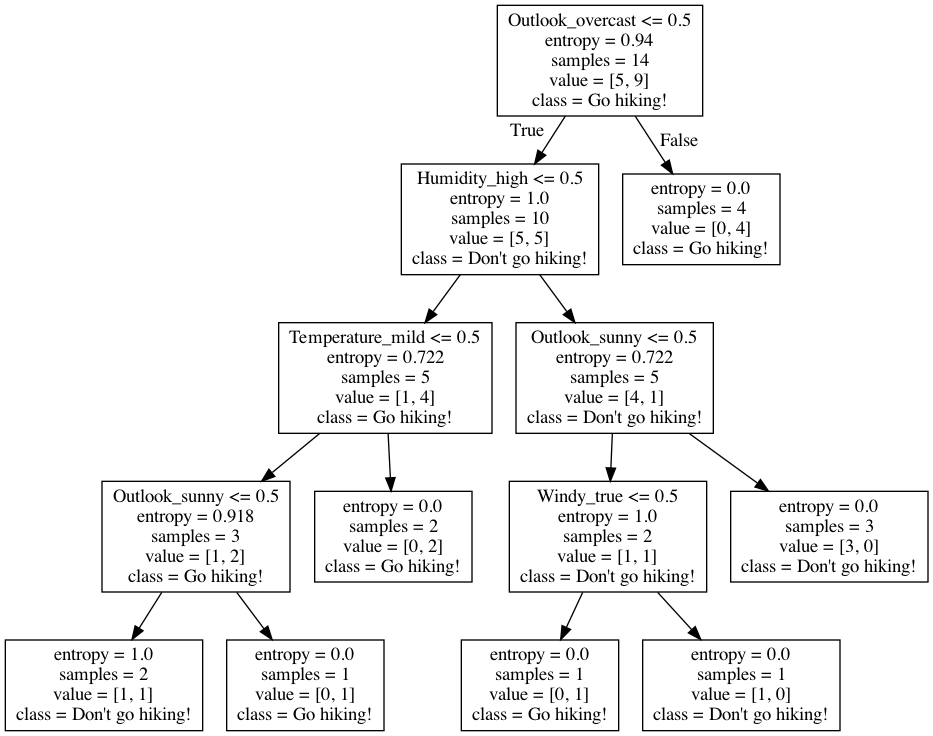

In [16]:
class_names = ["Don't go hiking!", "Go hiking!"]
t = visualize_tree(clf, X_.columns, class_names)
Image(t)

On each node, we can see:

* two different paths, indicated by each result of the test `(feature_value <= 0.5)`, applied to the current node. `True` means **all instances in this node for which `feature` IS NOT equal to `value`**. The left path is always True, and the right path is always False.
* the entropy in that node.
* the `value` array, which indicates how many samples reaching that node belong to each class (the classes are in ascending numerical order)
* the name of the majority class in the node (in case of a tie, the first class in numerical order is taken)

The CART algorithm can also be used for regression problems. In that case, you should use the `DecisionTreeRegressor` (refer to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)). To visualize a simple example, check out [this page](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html).

## Feature importance

A great characteristic of decision trees is that they allow us to compute **feature importance**: a score for each feature, based on how useful they are at predicting the target variable.

The importance of a feature is given by the decrease in node impurity (according to the criterion being used - in this case, the entropy), weighted by the proportion of samples reaching the node.

We can calculate the feature importance in the following way:

In [17]:
feature_importances = pd.Series(data=clf.feature_importances_, index=X_.columns)
feature_importances.sort_values(ascending=False)

Outlook_overcast    0.283411
Humidity_high       0.249079
Outlook_sunny       0.211799
Windy_true          0.179147
Temperature_mild    0.076563
Outlook_rain        0.000000
Temperature_cool    0.000000
Temperature_hot     0.000000
Humidity_normal     0.000000
Windy_false         0.000000
dtype: float64

By inspecting the visual representation of the tree, we can see that the `Windy_true` attribute has the highest information gain (from 1 to 0 on both leaves it generate), and therefore the highest decrease in node impurity. 

However, since not many samples reach that node (only 2 in the training set), this is not the most important feature, since it is not as relevant to predicting the class in the overall dataset. Compare it with the feature with the highest importance, `Outlook_overcast`, placed right at the root of the tree: despite not having as high of an information gain, it immediately allows us to classify 4 samples as "Go Hiking".

## Pros and cons

### Pros

Decision trees are a straightforward way to represent rules that:

* are simple to understand, interpret and visualize
* require little to no data preparation (for example, don't require data scaling and normalization)
* are able to handle numerical and categorical variables
* missing values in the data doesn't affect (to a larger extent) the process of building the tree
* are a white-box model, all decisions are replicable and easily explainable.

### Cons

Decision trees are extremely flexible and prone to creating over-complex trees that:
* small changes in the data can cause a large change in the structure of the decision tree causing instability
* usually involves higher time to train (leading to an increase in price as the complexity and time increase)
* Overfitting
* Overfitting
* Overfitting.

(Repetition makes perfect.)

Mechanisms such as pruning (removing sections of the tree) and setting the maximum depth of the tree help with overfitting. Let's see how we can configure the maximum tree depth with `sklearn`:

In [18]:
clf = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=2, 
    random_state=101
)
clf.fit(X_, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=101)

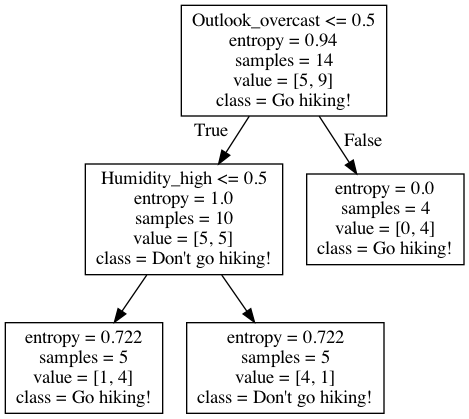

In [19]:
t = visualize_tree(clf, X_.columns, class_names)
Image(t)

We can also set the minimum number of samples required to split a node, in order to avoid fully-grown trees.

In [20]:
clf = DecisionTreeClassifier(
    criterion='entropy', 
    min_samples_split=5, 
    random_state=101
)
clf.fit(X_, y)

DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       random_state=101)

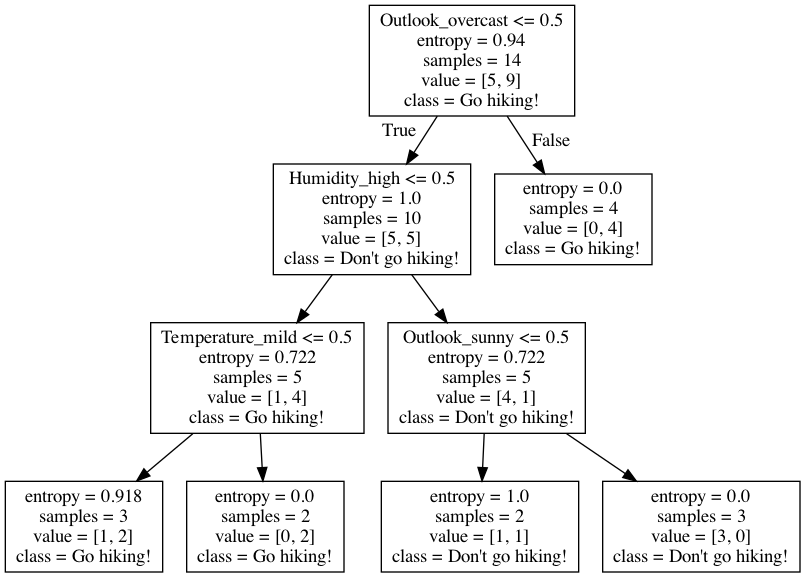

In [21]:
t = visualize_tree(clf, X_.columns, class_names)
Image(t)

These all help with controlling overfitting, but they might not be enough; and in fact, sometimes this approach is too heavy-handed, and might lead to underfitting. We will need to find a smarter way to control overfitting, while still allowing our trees to represent complex rules.

Some final notes:

* if the attributes are adequate, it is always possible to construct a decision-tree that correctly classifies every training instance.
* attributes are **inadequate** if the data contains two objects that have identical values for each attribute and yet belong to different classes.
* the key takeaway: **decision trees overfit like hell**.

## Tree-based ensembles <a class="anchor" id="tree-based-ensembles"></a>

**Ensemble methods** combine the predictions of several models, known as **base learners** or **base estimators**. Each individual estimator in the ensemble is often a "weak learner" (i.e. has slightly better accuracy than random). However, combining the predictions of the entire ensemble, we often get better results that are less prone to overfitting, when compared to using a single, larger model.


<img src="assets/ensemble-methods.png" alt="ensemble-methods" style="width: 600px;"/>

*Fig. 3: A simple ensemble model, using many trained models to generate a single prediction.*

There are homogeneous and heterogenous ensembles, based on whether the base learners are all of the same type or not.

We focus on homogenous ensembles of decision-trees, particularly:

* Building several independent trees and then average their predictions, so that variance is reduced (i.e., **bagging**)
* Building trees sequentially as to reduce the bias of the combined estimator (i.e., **boosting**).

# Bagging with random forests <a class="anchor" id="bagging-with-random-forests"></a>

Bootstrap aggregating, also known as bagging, consists in:

1. Creating several independent data sets 
2. Training a model in each data set
3. Aggregating individual predictions.

Bagging can be seen as training several independent models in parallel and averaging the predictions.

Imagine the following example: you are experiencing a strange feeling in your nose, and want to get a diagnosis. You have the option of going to a single, extremely-specialized podiatrist (that's a foot doctor, in case you didn't know, and in this analogy, it represents a single large model), or you could get your diagnosis from an association of 500 3rd year university students of medicine (which in this analogy represent a bag of simpler, shallower models).

Now, the podiatrist is very specialized: one might even say that he might have **overfit** to foot diseases. He might be able to extend his knowledge to your particular affliction and give a good diagnosis, but odds are he will diagnose you with something totally unrelated.
The group of 3rd year medicine students, on the other hand, might lack individual expertise; but if each of them has at least attended *some* classes, and *if they haven't all attended the same classes*, it's very likely that their collective knowledge surpasses the podiatrist's, and that their majority vote will be the right diagnosis. 

This example illustrates the main strength of bagging, which is that several weak models can cancel each other's weaknesses, provided that they are highly independent and were exposed to different information. 

But how does this relate to decision trees, you might ask? Well, decision-trees don't simply overfit, they are also highly unstable: small variations in the data result in wildly different trees.

This makes them particularly suited for bagging.

## Bagging

Suppose you have a sequence of data sets $\{D_1, D_2, \dots, D_k\}$, with observations from the same underlying distribution $\mathcal{D}$.

We can obtain an **ensemble of models**, $\{h_1, h_2, \dots, h_k\}$, by training a model in each data set.

<img src="assets/bagging-estimator.png" alt="bagging-estimator" style="width: 600px;"/>

*Fig. 4: In bagging different data sets are generated from the main one, models are trained in parallel and predictions averaged.*

By running the models in parallel, we get $\{\hat{y}_1\, \hat{y}_2\, \dots, \hat{y}_k\}$, a list of predictions from our ensemble.

To obtain a single prediction we can then evaluate all models and aggregate the results by:
* Averaging the $k$ predictions (regression)
* Using majority voting to predict a class (classification).

More often than not, however, we don't have multiple data sets. In this situation, we can do bootstrapping.

## Bootstrapping

We can take repeated random samples with replacement $\{C^1, C^2, \dots, C^b\}$ from $C$, our full dataset:

In [22]:
def make_bootstrap_data(data, b):
    n = data.shape[0]
    return [data.sample(n=n, replace=True) for i in range(b)]


bootstrap_data = make_bootstrap_data(data, 2)

Typically, the bootstrapped data sets are the same size as the original data set.

In [23]:
bootstrap_data[0]

,Outlook,Temperature,Humidity,Windy,Class
7,sunny,mild,high,false,0
8,sunny,cool,normal,false,1
4,rain,cool,normal,false,1
12,overcast,hot,normal,false,1
12,overcast,hot,normal,false,1
12,overcast,hot,normal,false,1
10,sunny,mild,normal,true,1
12,overcast,hot,normal,false,1
0,sunny,hot,high,false,0
6,overcast,cool,normal,false,1


In [24]:
bootstrap_data[1]

,Outlook,Temperature,Humidity,Windy,Class
2,overcast,hot,high,false,1
12,overcast,hot,normal,false,1
3,rain,mild,high,false,1
9,rain,mild,normal,false,1
9,rain,mild,normal,false,1
2,overcast,hot,high,false,1
4,rain,cool,normal,false,1
8,sunny,cool,normal,false,1
11,overcast,mild,high,true,1
1,sunny,hot,high,true,0


We would now train a different decision tree in each data set and use voting to predict whether or not to go hiking.

Bagging works very well in controlling overfitting and the generalization error in unstable models. If one of the models in the bag overfits to a certain noisy observation, it's very likely that its vote will be drowned out by the rest of the models in the ensemble.

## Random forests

A **random forest** is an ensemble learning method created by bagging multiple decision trees.
In random forests, bagging is used in tandem with random feature selection:

* Datasets are generated from the original data, using bootstrapping (row sampling)
* Then a tree is grown on each bootstrapped data set using random feature selection (column sampling).

Random feature selection means that only a random subset of the features is available at each split.

Randomizing features acts as a kind of regularization, further mitigating overfitting, because it forces each individual classifier to be as good as possible, while having access to limited information. This increases diversity inside the ensemble, which is often very beneficial.

Fortunately, `sklearn` implements all this intricate logic for us.

In [25]:
rf = RandomForestClassifier(
    n_estimators=10, 
    criterion='entropy',
    max_features=2, 
    bootstrap=True
)

rf.fit(X_, y)

RandomForestClassifier(criterion='entropy', max_features=2, n_estimators=10)

For detailed information about the models, check the documentation:
* RandomForestClassifier ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html))
* RandomForstsRegressor ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)).

Bagging is a great technique to reduce overfitting, and as such, to reduce the variance of our final predictions. This comes at the cost of interpretability - it is much easier to interpret the rules contained within a single decision tree, than it is to analyze the driving forces in a majority vote of hundreds or even thousands of models. 

# Boosting with gradient boosting <a class="anchor" id="boosting-with-gradient-boosting"></a>

**Boosting** is a different ensemble learning technique. In this case, instead of training several base learners in parallel and averaging their predictions, we train them sequentially; and the input of each model is the residual error of the previous model.

The general idea is to build strong ensembles by combining base learners sequentially, each of them correcting previous errors (and thus reducing bias).

**Note:** this section can be pretty intimidating at first, but don't despair! It will be worth it in the end.

## Boosting

Trees are grown sequentially, and each tree is created using information derived from the previous tree. In each iteration:

1. Errors and misclassifications of the past model are given increased weight in a new training data set
2. The current model is trained on the new training set, fitting the residual errors of the previous model.

As such, each model specializes in correcting past mistakes and misclassifications. 

<img src="assets/boosting-estimator.png" alt="boosting-estimator" style="width: 600px;"/>

Intuitively, this produces an ensemble of models that are good in different "parts" of the training data, as they sequentially correct each other's mistakes. The final prediction is obtained by summing the predictions of each model in the ensemble.

Boosting is less robust than bagging against overfitting, and as such, it is recommended to control the number of estimators used, the strength of each individual estimator, the learning rate, and use other regularization techniques.


In this example we will use the [boston](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) house-prices data set (regression).

In [26]:
def prepare_boston():
    boston = load_boston()
    X = pd.DataFrame(data=boston.data, columns=boston.feature_names)
    y = pd.Series(data=boston.target, name='price')
    
    return X, y


X_boston, y_boston = prepare_boston()

## What do we mean by "gradient" boosting

To understand the meaning of **gradient boosting**, we need to review a couple of concepts.

### Loss function

A loss function quantifies how bad our predictions are. An example is the squared error, seen below: 

$$L_i = (y_i - h(x_i))^2$$ 

As we can see, the square error increases with the square of the difference between each of our predictions, and the real value. The worse this error across all data samples, the worse will the overall model performance be.

The training of an individual machine learning model is driven by the minimization the total loss, over all observations in the training set, with respect to the model's parameters $\theta$: 

$$\min_{\theta} J = \sum_{i=1}^N L(y_i, h(x_i, \theta))$$

$h(x_i, \theta)$ represents our model's predictions, or $\hat{y}$.

### Gradient descent

The gradient of a loss function ($\nabla$), at each point, is its inclination or slope.

It's the fancy term for the multi-variable generalization of the derivative, i.e., the partial derivatives of function $f$ at a given point.

When training a model by gradient descent, we calculate, at each training step, the derivative of the loss $L$ with respect to the model's parameters, and then update the parameters by giving a small step in the opposite direction of this gradient - the direction in which the loss is decreasing:

$$\theta^{n+1} = \theta^{n} - \eta \nabla_{\theta} L(y, \hat{y})$$

As such, at each step, we are trying to gradually move our model to a location in parameter space where the loss function has a lower value.

## Gradient boosting in detail

We now have all pieces required to understand gradient boosting. Let's consider the case of a numerical target variable.

We have our first model in the boosting ensemble, $F^{(1)}(x, \theta)$. This model achieves a certain loss, given by $L(\textbf{y}, F^{(1)}(x, \theta))$. 

We now want to add a second model, $h$, to improve our first model in a way that 

$$
F^{(1)}(x_1) + h(x_1) = y_1 \\
F^{(1)}(x_2) + h(x_2) = y_2 \\
...
$$

or equivalently,

$$
h(x_1) = y_1 - F^{(1)}(x_1) \\
h(x_2) = y_2 - F^{(1)}(x_2) \\
...
$$

Maybe there isn't a single model that can achieve this. But perhaps some regression tree can do it approximately. We can try to fit it to the following data points:

$$
(x_1, y_1 - F^{(1)}(x_1)) \\
(x_2, y_2 - F^{(1)}(x_2)) \\
...
$$


$y_i - F^{(1)}(x_i)$ are called **residuals**. The role of $h$ is to be strong where the initial model was weak. And if the new model $F^{(2)} = F^{(1)} + h$ still isn't good enough, we can fit an additional regression tree to its residuals, and so on and so forth.

Taking a step back to our first model, imagine we are using the squared error loss function:

$$
L(\textbf{y},F_1(x)) = (\textbf{y} - F^{(1)}(x))^2
$$

We want to minimize $J = \sum_i{L(y_i, F^{(1)}(x_i))}$ by adjusting $F^{(1)}(x_1)$, $F^{(1)}(x_2)$, ...

Now, what we are truly adjusting during learning are the parameters $\theta$ of $F^{(1)}$. But if we take a functional perspective, we can observe that $F^{(1)}(x_i)$ are simply numbers - we can treat them as parameters and take derivatives:

$$
\begin{align}
\frac{\partial J}{\partial F^{(1)}(x_i)} & = \frac{\partial \sum_{j=0}^{n}{L(y_j, F^{(1)}(x_j))}}{\partial F^{(1)}(x_i)} \\
& = \frac{\partial L(y_i, F^{(1)}(x_i))}{\partial F^{(1)}(x_i)} \\
& = -2 (y_i - F^{(1)}(x_i)) \\
& = -2*residuals
\end{align}
$$

As you may have noticed, when the loss function is the squared error, the residuals are proportional to the negative gradients of the loss function!

Thus arises the similarity with gradient descent:

$$
\begin{align}
F^{(2)}(x_i) & = F^{(1)}(x_i) + h(x_i) \\
& = F^{(1)}(x_i) + y_i - F^{(1)}(x_i) \\
& = F^{(1)}(x_i) - \frac{1}{2}\frac{\partial J}{\partial F^{(1)}(x_i)} \\
\end{align}
$$

and

$$
\theta^{n+1} = \theta^{n} - \eta \frac{\partial J}{\partial F(\theta_i)}
$$


To summarize: for regression with **square loss**,

* the residual <=> negative gradient
* fitting h to the residual <=> fitting h to the negative gradient
* adding a new estimator based on the residual <=> adding a new estimator based on the negative gradient

When adding a new estimator to our boosting ensemble, we are actually minimizing a global loss function by using gradient descent, in function space!

The final thing to understand here is that the concept of gradients is more useful than the concept of residuals, because it allows us to generalize to loss functions other than the squared error. As long as we fit each additional model to the negative gradients of the current global model, we will be minimizing our desired global loss function.

## In practice

Let's implement one step of a boosting algorithm, for when the loss function is the mean squared error, based on what we have discussed so far!

### Initialization

We initialize all $F^{(1)}(x_i)$ to a sensible constant, $F^{(1)}(x_i) = \gamma$.

Since our goal is to minimize the mean squared error, we will use the mean value of the target variable in the training set.

In [27]:
y_boston_h0_pred = np.repeat(y_boston.mean(), y_boston.size)

We compute the mean squared error of this initial set of predictions.

In [28]:
mean_squared_error(y_boston, y_boston_h0_pred)

84.41955615616556

### Iterations

#### Generating a new data set

We build a new training set at the start of each iteration, by recomputing the target variable to be the gradient of the previous model.

More concretely, at the $j$-th iteration we compute a new target variable $r^{(j)}_i$, corresponding to the gradient of the past iteration:

$$r^{(j)}_{i} = \frac{\partial L(y_i, F^{(j-1)}(x_i))}{\partial F^{(j-1)}(x_i)} = -2(r^{(j-1)}_{i} - F^{(j-1)}(x_i))$$

For the first iteration:

* $r^{(j-1)}_i = y_i$, the original targets
* $F^{(j-1)}(x_i)) = F^{(1)}(x_i) = \gamma$

In [29]:
def compute_gradient(y, y_pred):
    return -2 * (y - y_pred)


y_boston_h0_residual = compute_gradient(y_boston, y_boston_h0_pred)

#### Training a decision-tree

We now fit a new decision-tree to the negative gradient that we just calculated, $r^{(j)}_i$:

In [30]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_boston, y_boston_h0_residual)

y_boston_h0_residual_pred = dt.predict(X_boston)

Typically, we will want to train the simplest, shallowest decision-trees as base learners, to avoid overfitting (which is why we are setting the maximum depth of the tree to one.)

#### Updating the global model

We now want to add the predictions made by this model (over the residuals) to the predictions made by the base model. The update rule goes as follows, where $\eta$ is a **learning rate** that controls the magnitude of the update and acts as a regularizer:

$$F^{(j)}(x_i)) = F^{(j-1)}(x_i)) - \eta \cdot \frac{\partial L(y_i, F^{(j-1)}(x_i))}{\partial F^{(j-1)}(x_i)}$$

The learning rate is also known as the *shrinkage factor*, as it shrinks the impact of the corrections if $\eta$ between 0 and 1.

Since we don't know the true value of $y_i$ at prediction time, we plug-in the prediction of the decision-tree we  fit in the previous step:

$$F^{(j)}(x_i)) \approx F^{(j-1)}(x_i)) - \eta \cdot \hat{r}^{(j)}_i(x_i) $$

If everything goes well, with each step we are moving closer and closer to the function that minimizes the squared error.

In [31]:
def update_predictions(previous_prediction, residual_prediction, lr):
    return previous_prediction - lr * residual_prediction


y_boston_h1_pred = update_predictions(y_boston_h0_pred, y_boston_h0_residual_pred, lr=0.1)

Now, we compute the mean squared error for the updated predictions.

In [32]:
mean_squared_error(y_boston, y_boston_h1_pred)

70.660188943705

Hurrah! The error decreased. We would continue the process until the error stopped decreasing, or until we detected signs of overfitting.

### Putting it all together

Suppose we have $m$ individual decision-trees (boosting stages)

The final prediction will be given by the sum of the initial constant and all the gradient-based corrections:

$$F^m_i(x_i) = \gamma + \sum_{j=1}^m \eta \cdot \hat{r}^{(j)}_i(x_i)$$

Where $\hat{r}^{(j)}_i(x_i)$ is the output of a decision-tree that predicts the negative gradient of the previous iteration.

A final note: don't worry if you didn't understand all the details of previous section - it was quite heavy on the mathematical side. Just make sure you understand the basics of boosting and the idea behind it, and `sklearn` has got you covered!


## With sklearn

Enough with theory: `sklearn` to the rescue! Let's create a `GradientBoostingClassifier`, which can be used for classification problems:

In [33]:
gb = GradientBoostingClassifier(
    learning_rate=.1,
    n_estimators=10
)

gb.fit(X_, y)

GradientBoostingClassifier(n_estimators=10)

#### Include sampling

Some implementations provide the ability to sample observations and features at each iteration, similarly to what happens with Random Forests. Unsurprisingly, this reduces overfitting at the expense of increased bias.

In [34]:
gb = GradientBoostingClassifier(
    learning_rate=.1, 
    n_estimators=10, 
    subsample=.5
)
gb.fit(X_, y)

GradientBoostingClassifier(n_estimators=10, subsample=0.5)

# Conclusion

You are now armed with the power of bagging and boosting, two techniques you can easily use to obtain models with a lot of expressive power that also generalize better! Hopefully, you also got some insight into the world of more advanced machine learning techniques.

Make sure to review this notebook well, and when you're ready, go solve the exercises. Good luck!